# Imports

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Env, spaces
from IPython.display import clear_output
import time

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Env, spaces
from IPython.display import clear_output

class PacketSchedulerEnv(Env):
    """
    OpenAI Gymnasium environment simulating packet scheduling across three queues:
    """

    def __init__(self, scenario=1):
        """
        Constructor
        takes the scenario 1 or 2 as arguments
        """
        super().__init__()
        self.num_queues = 3
        self.max_queue_size = 50
        self.scenario = scenario
        self.current_queue = 0
        self.time = 0

        self.qos_limits = [6, 4, None]
        self.arrival_probs = [0.3, 0.25, 0.4]

        self.observation_space = spaces.Box(
            low=0, high=self.max_queue_size, shape=(self.num_queues,), dtype=np.int32
        )
        self.action_space = spaces.Discrete(self.num_queues if scenario == 1 else 2)

        self.history = []
        self.reset()

    def reset(self, seed=None, options=None):
        """Reset the environment to the initial state."""
        super().reset(seed=seed)
        self.initialize_queues()
        self.reset_state()
        return self.get_observations(), {}

    def initialize_queues(self):
        """Initialize empty queues for each traffic class."""
        self.queues = [[] for _ in range(self.num_queues)]

    def reset_state(self):
        """Reset simulation states"""
        self.time = 0
        self.current_queue = 0
        self.history = []
        self.served_delays = [[] for _ in range(self.num_queues)]
        self.violations = [0, 0]

    def get_observations(self):
        """Return the current queue length observations"""
        return np.array([len(q) for q in self.queues])

    def generate_packets(self):
        """Randomly generate packets based on per-queue arrival rates."""
        for queue_id, rate in enumerate(self.arrival_probs):
            if self.should_generate_packet(rate):
                self.try_enqueue_packet(queue_id, self.time)

    def should_generate_packet(self, rate):
        """True if packets should be generated ."""
        return np.random.rand() < rate

    def try_enqueue_packet(self, queue_id, arrival_time):
        """Add packet to queue if not full."""
        if len(self.queues[queue_id]) < self.max_queue_size:
            self.queues[queue_id].append(arrival_time)

    def serve_queue(self, queue_idx):
        """Serves to Queue"""
        if not self.queue_has_packets(queue_idx):
            return self.empty_queue_penalty()

        arrival_time = self.queues[queue_idx].pop(0)
        delay = self.compute_packet_delay(arrival_time)

        self.served_delays[queue_idx].append(delay)

       # check if vid and voice violates qos 
        if queue_idx < 2 and delay > self.qos_limits[queue_idx]:
            self.violations[queue_idx] += 1

        return self.compute_reward(queue_idx, delay)

    def queue_has_packets(self, queue_idx):
        """Checks if thee's at least one packet in queue"""
        return len(self.queues[queue_idx]) > 0

    def empty_queue_penalty(self):
        """empty queue serve penalty"""
        return -1

    def compute_packet_delay(self, arrival_time):
        """Compute the delay for packet"""
        return self.time - arrival_time

    def compute_reward(self, queue_idx, delay):
        """Compute reward based on delay and QoS constraints."""
        qos_limit = self.qos_limits[queue_idx]
        if qos_limit is not None:
            return 1 if delay <= qos_limit else -1
        else:
            return max(0, 1 - 0.05 * delay)

    def process_action(self, action):
        """Choses which queue to serve"""
        if self.scenario == 1:
            return action, 0
        elif self.scenario == 2:
            if action == 1:
                self.switch_queue()
                return None, -0.2
            else:
                return self.current_queue, 0

    def switch_queue(self):
        """sitching queue"""
        self.current_queue = (self.current_queue + 1) % self.num_queues
        self.time += 1

    def serve_and_advance(self, queue_idx):
        """serve from queue and increment time +1"""
        reward = self.serve_queue(queue_idx)
        self.time += 1
        return reward

    def step(self, action):
        """simulates single unit of time in router operation"""
        self.generate_packets()
        selected_queue, reward = self.process_action(action)

        if selected_queue is not None:
            reward = self.serve_and_advance(selected_queue)

        terminated = False
        truncated = False
        return self.get_observations(), reward, terminated, truncated, {}

    def draw_network_quue(self):
        """visual output to see traffic"""
        queue_lengths = [len(q) for q in self.queues]
        self.history.append(queue_lengths)

        clear_output(wait=True)
        plt.figure(figsize=(5, 4))
        plt.bar(["Video", "Voice", "Best-Effort"], queue_lengths, color=["blue", "orange", "green"])
        plt.ylim(0, self.max_queue_size)
        plt.title(f"Time Step: {self.time}")
        plt.ylabel("Packets in Queue")
        plt.grid(True)
        plt.show()

    def get_statistics(self):
        """To check output statistics."""
        queue_lengths = [len(q) for q in self.queues]
        total_packets = [len(q) for q in self.served_delays]
        mean_delays = [np.mean(q) if q else None for q in self.served_delays]
        violation_rates = [
            self.violations[i] / max(1, len(self.served_delays[i]))
            for i in range(2)
        ]

        return {
            'queue_lengths': queue_lengths,
            'total_packets': total_packets,
            'mean_delays': mean_delays,
            'qos_violations': self.violations,
            'violation_rates': violation_rates
        }


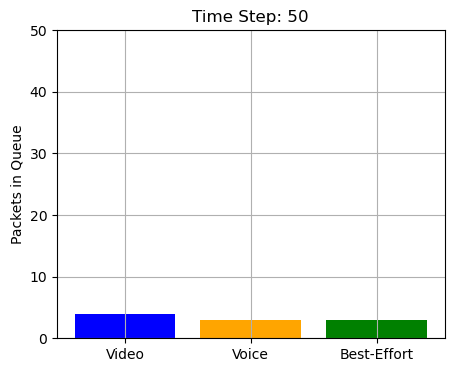

In [9]:
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

for _ in range(50):
    action = env.action_space.sample()  # Random policy
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_quue()
    time.sleep(0.2)


In [10]:
env.get_statistics()

{'queue_lengths': [4, 3, 3],
 'total_packets': [12, 13, 11],
 'mean_delays': [1.5, 9.153846153846153, 6.363636363636363],
 'qos_violations': [0, 11],
 'violation_rates': [0.0, 0.8461538461538461]}